uploading docs


In [ ]:


from google.colab import files
uploaded = files.upload()


In [ ]:
# prompt: unzip uploaded file

import zipfile
import io

zf = zipfile.ZipFile(io.BytesIO(uploaded['paddypest.zip']), "r")
zf.extractall()


preprocessing

In [ ]:
import torch
from torchvision import datasets, transforms, utils

# Define transformations for the training and validation sets
train_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

val_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Load the datasets with ImageFolder
train_data = datasets.ImageFolder('paddypest/train', transform=train_transforms)
val_data = datasets.ImageFolder('paddypest/valid', transform=val_transforms)

# Define the dataloaders
train_loader = torch.utils.data.DataLoader(train_data, batch_size=32, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_data, batch_size=32, shuffle=True)


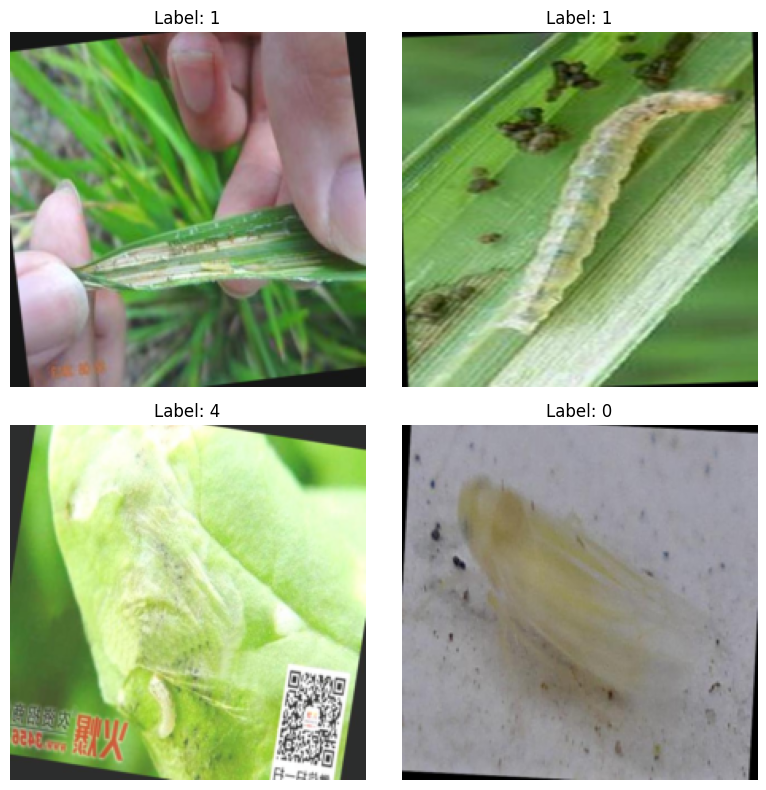

In [ ]:
# prompt: display preprocessed images

import matplotlib.pyplot as plt
import numpy as np

# Get a batch of training data
images, labels = next(iter(train_loader))

# Display some images
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(8, 8))
for i in range(4):
  # Unnormalize the image
  image = images[i].numpy().transpose((1, 2, 0))
  mean = np.array([0.485, 0.456, 0.406])
  std = np.array([0.229, 0.224, 0.225])
  image = std * image + mean
  image = np.clip(image, 0, 1)

  # Display the image
  row = i // 2
  col = i % 2
  axes[row, col].imshow(image)
  axes[row, col].set_title(f"Label: {labels[i]}")
  axes[row, col].axis('off')

plt.tight_layout()
plt.show()


alexnet

In [ ]:
import torch.nn as nn
import torch.optim as optim
from torchvision import models

# Load the pre-trained AlexNet model
model = models.alexnet(pretrained=True)

# Modify the classifier to match the number of classes (2 in this case)
model.classifier[6] = nn.Linear(4096, 5)

# Define the loss function and the optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

# Move the model to GPU if available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)

# Training the model
n_epochs = 10

for epoch in range(n_epochs):
    model.train()
    running_loss = 0.0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f"Epoch {epoch+1}/{n_epochs}, Loss: {running_loss/len(train_loader)}")


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/10, Loss: 0.6001840856779053
Epoch 2/10, Loss: 0.2295868820454701
Epoch 3/10, Loss: 0.11237913568739791
Epoch 4/10, Loss: 0.07934214527079139
Epoch 5/10, Loss: 0.05027702187625579
Epoch 6/10, Loss: 0.05531876501052203
Epoch 7/10, Loss: 0.024783537282709437
Epoch 8/10, Loss: 0.019162888572753285
Epoch 9/10, Loss: 0.02623971139013498
Epoch 10/10, Loss: 0.020246744198619084


model evaluation

In [ ]:
model.eval()
correct = 0
total = 0

with torch.no_grad():
    for inputs, labels in val_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy: {100 * correct / total}%')


Accuracy: 10.86261980830671%


In [ ]:
# prompt: how to test with a single image

from PIL import Image

# Load the image
image_path = 'poochi.jpg'  # Replace with the actual path
image = Image.open(image_path)

# Preprocess the image
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])
image = transform(image).unsqueeze(0).to(device)  # Add batch dimension

# Make prediction
model.eval()
with torch.no_grad():
    output = model(image)
    _, predicted = torch.max(output.data, 1)

# Get the class names
class_names = train_data.classes

# Print the predicted class
print(f'Predicted class: {class_names[predicted.item()]}')


Predicted class: RICE BUGS
